<a href="https://colab.research.google.com/github/saintblue97/DeepNN_Optiver/blob/main/brett_10_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# !pip install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
# # !mkdir -p ~/.kaggle                                           # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
# # !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
# #!cp kaggle.json ~/.kaggle/kaggle.json > log                   # Alternative location of kaggle.json (without a connection to Google Drive)
# # !chmod 600 ~/.kaggle/kaggle.json                              # give only the owner full read/write access to kaggle.json
# !kaggle config set -n competition -v optiver-trading-at-the-close        # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
# !kaggle competitions download >> log                          # download competition dataset as a zip file
# !unzip -o *.zip >> log                                        # Kaggle dataset is copied as a single file and needs to be unzipped.
# # !kaggle competitions leaderboard --show                       # print public leaderboard

In [1]:
%%time
%%capture
%reset -f
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, xgboost, lightgbm as lgb

ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=300): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=2, suppress=True)
pd.set_option('display.max_columns', 50, 'display.precision', 2, 'display.max_rows', 50)

CPU times: user 695 ms, sys: 867 ms, total: 1.56 s
Wall time: 602 ms


In [2]:
# def is_google_colab():
#     """Check if the environment is Google Colab.

#     Returns:
#         bool: True if in Google Colab, False otherwise.
#     """
#     try:
#         import google.colab
#         return True
#     except ImportError:
#       return False

# if is_google_colab():
#   file_path = ''
# else:
#   file_path = '/kaggle/input/optiver-trading-at-the-close/'

In [4]:
file_path = ''

sample_submission_path = file_path + 'example_test_files/sample_submission.csv'

sample_submission = pd.read_csv(sample_submission_path); sample_submission

,time_id,row_id,target
0,26290,478_0_0,0
1,26290,478_0_1,0
2,26290,478_0_2,0
3,26290,478_0_3,0
4,26290,478_0_4,0
...,...,...,...
32995,26454,480_540_195,0
32996,26454,480_540_196,0
32997,26454,480_540_197,0
32998,26454,480_540_198,0


# Load Data

In [5]:
train_data_path = file_path + 'train.csv'
df = pd.read_csv(train_data_path);
df = df.dropna(subset=['target']).reset_index(drop=True); df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3.18e+06,1,1.0,1.34e+07,NaN,NaN,1.0,60651.50,1.0,8493.03,1.0,-3.03,0,0_0_0
1,1,0,0,1.67e+05,-1,1.0,1.64e+06,NaN,NaN,1.0,3233.04,1.0,20605.09,1.0,-5.52,0,0_0_1
2,2,0,0,3.03e+05,-1,1.0,1.82e+06,NaN,NaN,1.0,37956.00,1.0,18995.00,1.0,-8.39,0,0_0_2
3,3,0,0,1.19e+07,-1,1.0,1.84e+07,NaN,NaN,1.0,2324.90,1.0,479032.40,1.0,-4.01,0,0_0_3
4,4,0,0,4.48e+05,-1,1.0,1.79e+07,NaN,NaN,1.0,16485.54,1.0,434.10,1.0,-7.35,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237887,195,480,540,2.44e+06,-1,1.0,2.83e+07,1.0,1.0,1.0,32257.04,1.0,319862.40,1.0,2.31,26454,480_540_195
5237888,196,480,540,3.50e+05,-1,1.0,9.19e+06,1.0,1.0,1.0,205108.40,1.0,93393.07,1.0,-8.22,26454,480_540_196
5237889,197,480,540,0.00e+00,0,1.0,1.27e+07,1.0,1.0,1.0,16790.66,1.0,180038.32,1.0,1.17,26454,480_540_197
5237890,198,480,540,1.00e+06,1,1.0,9.48e+07,1.0,1.0,1.0,125631.72,1.0,669893.00,1.0,-1.54,26454,480_540_198


In [6]:
test_data_path = file_path + 'example_test_files/test.csv'
df_test  = pd.read_csv(test_data_path); df_test

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id,currently_scored
0,0,478,0,3.75e+06,-1,1.0,1.15e+07,NaN,NaN,1.0,22940.00,1.0,9177.60,1.0,26290,478_0_0,False
1,1,478,0,9.86e+05,-1,1.0,3.85e+06,NaN,NaN,1.0,1967.90,1.0,19692.00,1.0,26290,478_0_1,False
2,2,478,0,5.99e+05,1,1.0,4.36e+06,NaN,NaN,1.0,4488.22,1.0,34955.12,1.0,26290,478_0_2,False
3,3,478,0,2.87e+06,-1,1.0,2.71e+07,NaN,NaN,1.0,16082.04,1.0,10314.00,1.0,26290,478_0_3,False
4,4,478,0,7.40e+05,-1,1.0,8.88e+06,NaN,NaN,1.0,19012.35,1.0,7245.60,1.0,26290,478_0_4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32995,195,480,540,2.44e+06,-1,1.0,2.83e+07,1.0,1.0,1.0,32257.04,1.0,319862.40,1.0,26454,480_540_195,False
32996,196,480,540,3.50e+05,-1,1.0,9.19e+06,1.0,1.0,1.0,205108.40,1.0,93393.07,1.0,26454,480_540_196,False
32997,197,480,540,0.00e+00,0,1.0,1.27e+07,1.0,1.0,1.0,16790.66,1.0,180038.32,1.0,26454,480_540_197,False
32998,198,480,540,1.00e+06,1,1.0,9.48e+07,1.0,1.0,1.0,125631.72,1.0,669893.00,1.0,26454,480_540_198,False


In [7]:
# Split dataframe into X and y
X, y = df.drop('target', axis=1), df.target

### Create train/validation/test splits

In [8]:
def create_train_test_split(X, y, random_seed=42, test_size=0.2):
    np.random.seed(random_seed)
    
    ### Need to create train/test split for each stock_id
    stock_ids = X.stock_id.unique()
    date_ids  = X.date_id.unique()

    stock_size = int(len(stock_ids)*test_size)
    date_size  = int(len(date_ids)*test_size)

    test_stock_ids = np.sort(
        np.random.choice(stock_ids, size=stock_size, replace=False)
    )
    test_date_ids = np.sort(
        np.random.choice(date_ids, size=date_size, replace=False)
    )
 
    X_test = X.query(f"stock_id in @test_stock_ids and date_id in @test_date_ids")
    y_test = y[X_test.index]
    return X_test, y_test

In [9]:
def create_train_test_split(X, y, test_size=0.2):    
    ### Need to create train/test split for each stock_id
    size = int(len(X)*test_size)
    train_idxs, test_idxs = X.index[:-size], X.index[-size:]

    X_train, X_test = X.iloc[train_idxs], X.iloc[test_idxs]
    y_train, y_test = y[train_idxs], y[test_idxs]

    return X_train, X_test, y_train, y_test

In [10]:
X_train, X_valid, y_train, y_valid = create_train_test_split(X, y)

In [11]:
print('Shape of training data    =', X_train.shape)
print('Shape of validation data  =', X_valid.shape)
print('Shape of testing data     =', df_test.shape)

Shape of training data    = (4190314, 16)
Shape of validation data  = (1047578, 16)
Shape of testing data     = (33000, 17)


### EDA

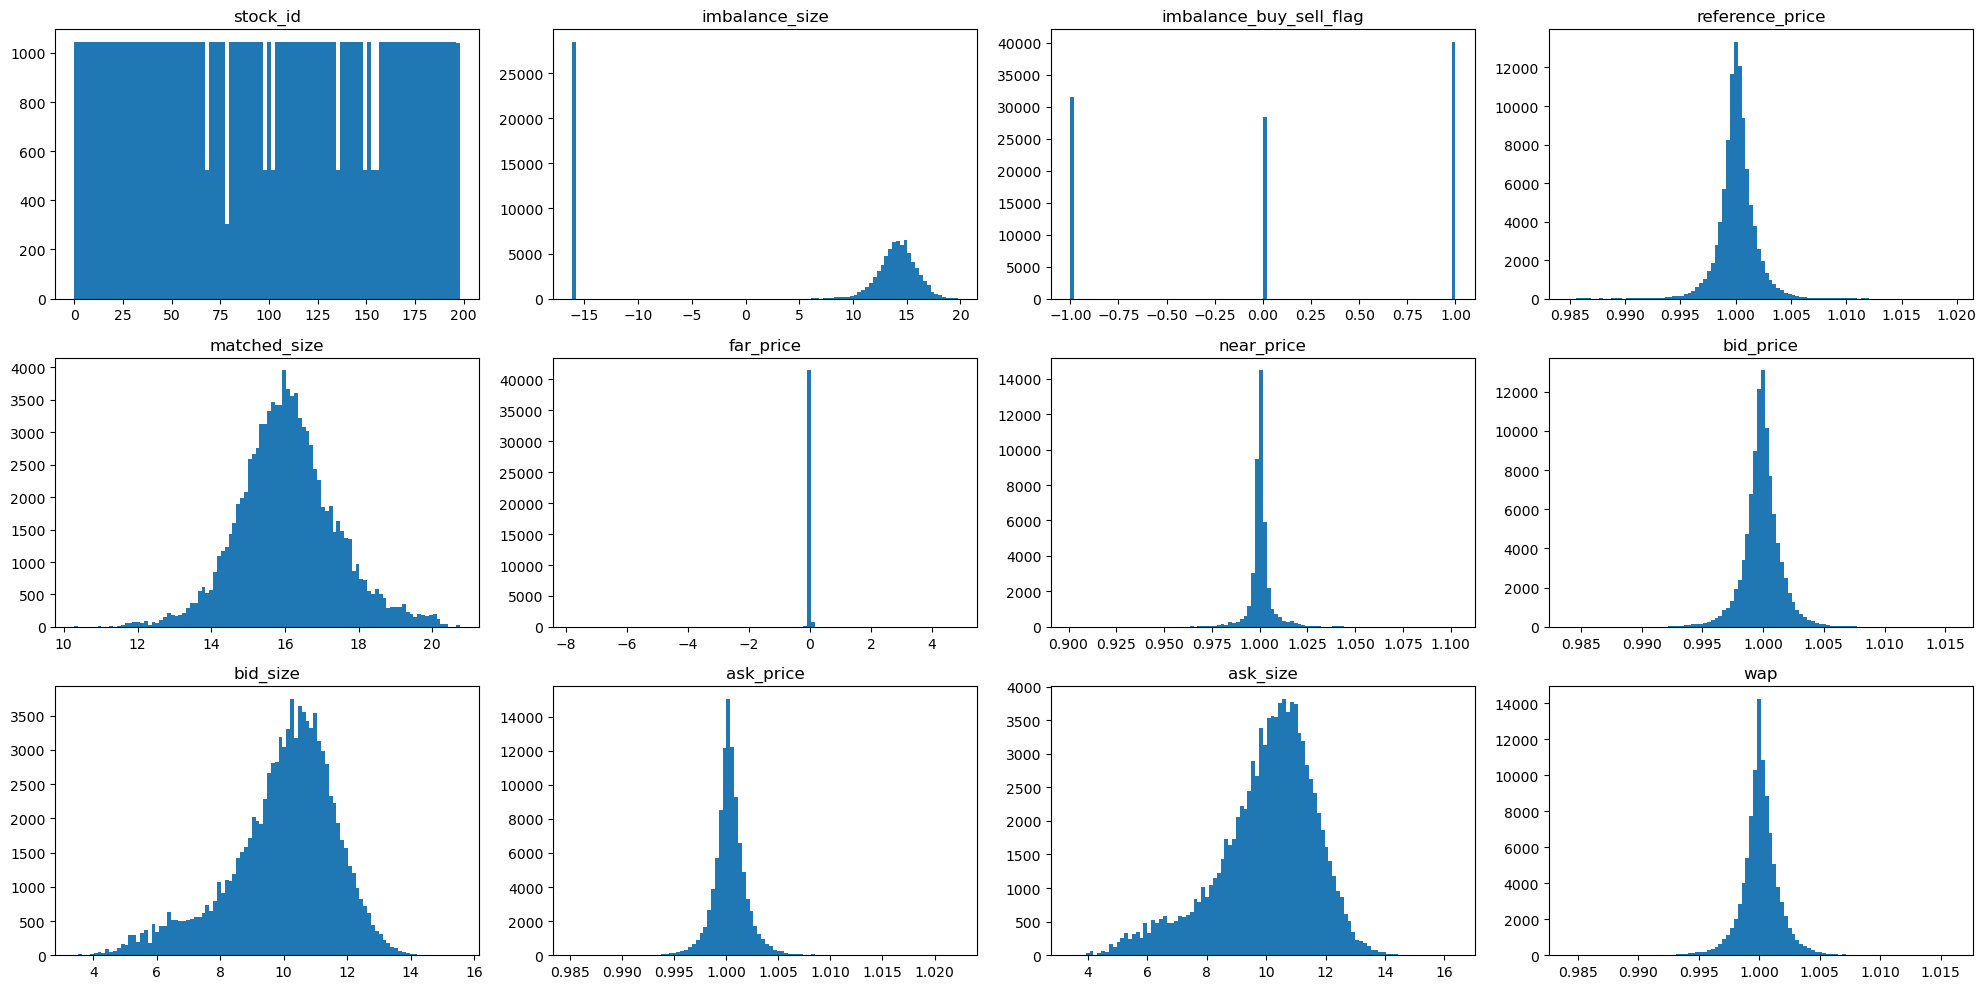

In [32]:
# Look at distributions of features
n_samples = 100000
feats = df.loc[:, ~df.columns.isin(["date_id", "seconds_in_bucket", "time_id", "row_id", "target"])] .columns
plt.figure(1, figsize=(20, 10))
for i, feat in enumerate(feats):
    plt.subplot(3, 4, i+1)
    if feat in ['imbalance_size', 'far_price', 'bid_size', 'matched_size', 'ask_size']:
        plt.hist(np.log(df.loc[:n_samples, feat] + 0.0000001), bins=100)
    else:
        plt.hist(df.loc[:n_samples, feat], bins=100)
    plt.title(feat)

plt.tight_layout()

In [170]:
# Check for null values
df.isna().any()

stock_id                   False
date_id                    False
seconds_in_bucket          False
imbalance_size              True
imbalance_buy_sell_flag    False
reference_price             True
matched_size                True
far_price                   True
near_price                  True
bid_price                   True
bid_size                   False
ask_price                   True
ask_size                   False
wap                         True
target                     False
time_id                    False
row_id                     False
dtype: bool

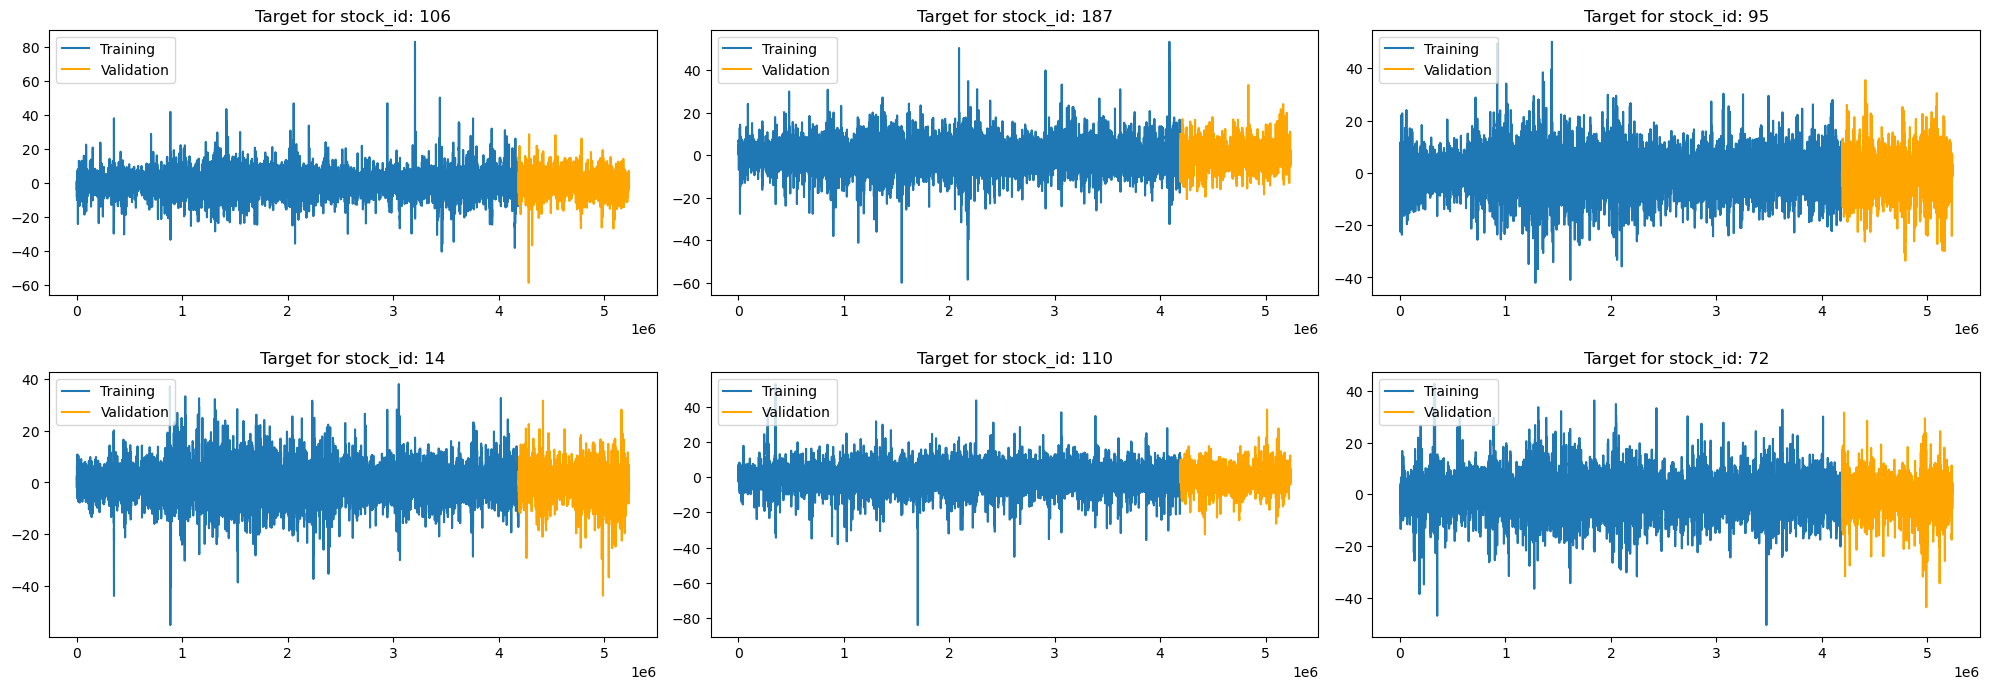

In [161]:
def plot_stock_target(
    X_train,
    X_valid,
    y_train,
    y_valid,
    stock_id,
    ax
):
    train_idxs = X_train.query(f"stock_id == {stock_id}").index
    valid_idxs = X_valid.query(f"stock_id == {stock_id}").index

    ax.plot(y_train[train_idxs], label="Training")
    ax.plot(y_valid[valid_idxs], color='orange', label="Validation")
    ax.set_title(f"Target for stock_id: {stock_id}")
    ax.legend(loc='upper left');

np.random.seed(42)
stock_ids = np.random.choice(tX.stock_id.unique(), size=6)
fig = plt.figure(1, figsize=(20, 10))
for i, stock_id in enumerate(stock_ids):
    ax = plt.subplot(3, 3, i+1)
    plot_stock_target(
        X_train,
        X_valid,
        y_train,
        y_valid,
        stock_id,
        ax
    )

plt.tight_layout()

In [26]:
import seaborn as sns

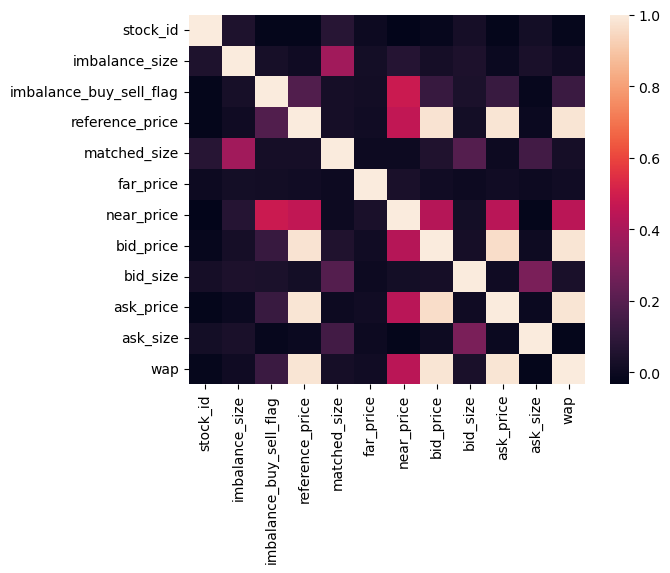

In [29]:
# Plot correlation matrix
sns.heatmap(df.loc[:n_samples, feats].corr());

In [8]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler,OneHotEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import ARDRegression, BayesianRidge, LinearRegression, Ridge, Lars
from itertools import combinations
import gc
import os
import time

In [9]:
# n_val = 50000

tX, tY = df.drop('target', axis=1), df.target    # full training set

# X_train = tX
# y_train = tY

# from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(tX, tY, test_size=0.1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1)

# Preprocessing

In [10]:
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Only drop columns that exist in X
        columns_to_drop = [col for col in self.columns_to_drop if col in X.columns]
        return X.drop(columns_to_drop, axis=1)

class DataFrameSimpleImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='mean', fill_value=None):
        self.strategy_ = strategy
        self.fill_value_ = fill_value

    def fit(self, X, y=None):
        if self.strategy_ == 'mean':
            self.fill_values_ = X.mean()
        elif self.strategy_ == 'median':
            self.fill_values_ = X.median()
        elif self.strategy_ == 'constant':
            if self.fill_value_ is None:
                raise ValueError("fill_value must be provided for strategy='constant'")
            self.fill_values_ = pd.Series(self.fill_value_, index=X.columns)
        else:
            raise ValueError(f"Unknown strategy type: {self.strategy_}")

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill_values_)

class MovingAverageTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, window_size, columns):
        self.window_size = window_size  # The size of the window for moving average
        self.columns = columns          # The columns on which to apply moving average

    def fit(self, X, y=None):
        return self  # No fitting process, so just return self

    def calculate_moving_average(self, series):
        return series.rolling(window=self.window_size).mean()

    def transform(self, X):
        X_new = X.copy()

        for col in self.columns:
            X_new[f'{col}_sma_{self.window_size}'] = X_new.groupby('stock_id')[col].transform(self.calculate_moving_average)

            X_new[f'{col}_sma_{self.window_size}'].fillna(X_new[col], inplace=True)


        return X_new


In [11]:
# generate imbalance features
import numpy as np
import pandas as pd
from itertools import combinations

def imbalance_features(df):
    df = df.copy()
    prices = ["reference_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size"]

    df.loc[:, "volume"] = df["ask_size"] + df["bid_size"]
    df.loc[:, "mid_price"] = (df["ask_price"] + df["bid_price"]) / 2
    df.loc[:, "liquidity_imbalance"] = (df["bid_size"] - df["ask_size"]) / (df["bid_size"] + df["ask_size"])

    for c in combinations(prices, 2):
        df.loc[:, f"{c[0]}_{c[1]}_imb"] = (df[c[0]] - df[c[1]]) / (df[c[0]] + df[c[1]])

    df.loc[:, "stock_weights"] = df["stock_id"].map(weights_dict)
    df.loc[:, "weighted_wap"] = df["stock_weights"] * df["wap"]
    df.loc[:, "price_spread"] = df["ask_price"] - df["bid_price"]
    df.loc[:, "spread_depth_ratio"] = df["price_spread"] / (df['bid_size'] + df['ask_size'])

    df.loc[:, f"all_prices_mean"] = df[prices].mean(axis=1)
    df.loc[:, f"all_prices_std"] = df[prices].std(axis=1)
    df.loc[:, f"all_sizes_mean"] = df[sizes].mean(axis=1)
    df.loc[:, f"all_sizes_std"] = df[sizes].std(axis=1)

    return df



def other_features(df):
    df = df.copy()
    df.loc[:, "dow"] = df["date_id"] % 5
    df.loc[:, "dom"] = df["date_id"] % 20
    df.loc[:, "seconds"] = df["seconds_in_bucket"] % 60
    df.loc[:, "minute"] = df["seconds_in_bucket"] // 60

    for key, value in global_stock_id_feats.items():
        df.loc[:, f"global_{key}"] = df["stock_id"].map(value.to_dict())

    return df

# generate all features
def generate_all_features(df):
    df = df.copy()
    cols = [c for c in df.columns if c not in ["row_id", "time_id", "target"]]
    df = df[cols]
    df = imbalance_features(df)
    df = other_features(df)
    gc.collect()

    feature_name = [i for i in df.columns if i not in ["row_id", "target", "time_id", "date_id"]]

    return df[feature_name]

def compute_triplet_imbalance(df_values, comb_indices):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))

    for i in range(num_combinations):
        a, b, c = comb_indices[i]
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val
            if mid_val == min_val:  # Prevent division by zero
                imbalance_features[j, i] = np.nan
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)

    return imbalance_features

def calculate_triplet_imbalance_numba(price, df):
    # Convert DataFrame to numpy array for Numba compatibility
    df_values = df[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]

    # Calculate the triplet imbalance
    features_array = compute_triplet_imbalance(df_values, comb_indices)

    # Create a DataFrame from the results
    columns = [f"{a}_{b}_{c}_imb2" for a, b, c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)

    return features

In [12]:
class ImbalanceFeaturesTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # No fitting process needed

    def transform(self, X):
        # Make sure that imbalance_features returns a DataFrame
        transformed_X = imbalance_features(X)
        return transformed_X


class OtherFeaturesTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # No fitting process needed

    def transform(self, X):
        return other_features(X)


class AllFeaturesTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # No fitting process needed

    def transform(self, X):
        return generate_all_features(X)


In [13]:
weights = [
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
]

global_stock_id_feats = {
        "median_size": df.groupby("stock_id")["bid_size"].median() + df.groupby("stock_id")["ask_size"].median(),
        "std_size": df.groupby("stock_id")["bid_size"].std() + df.groupby("stock_id")["ask_size"].std(),
        "ptp_size": df.groupby("stock_id")["bid_size"].max() - df.groupby("stock_id")["bid_size"].min(),
        "median_price": df.groupby("stock_id")["bid_price"].median() + df.groupby("stock_id")["ask_price"].median(),
        "std_price": df.groupby("stock_id")["bid_price"].std() + df.groupby("stock_id")["ask_price"].std(),
        "ptp_price": df.groupby("stock_id")["bid_price"].max() - df.groupby("stock_id")["ask_price"].min(),
    }

In [14]:
# Convert weights list to a dictionary
stock_ids = range(len(weights))  # Replace this with your actual stock IDs if they are different
weights_dict = dict(zip(stock_ids, weights))

In [15]:
from sklearn.compose import ColumnTransformer

# Set up preprocessing pipeline
preprocess_steps = [
    ('drop_columns', DropColumns(['time_id', 'currently_scored'])),
    ('imputer1', DataFrameSimpleImputer(strategy='constant', fill_value=0)),
    ('moving_average', MovingAverageTransformer(window_size=2, columns=['ask_size', 'ask_price', 'bid_price', 'ask_size', 'reference_price', 'wap'])),
    ('imbalance_features', ImbalanceFeaturesTransformer()),
    ('other_features', OtherFeaturesTransformer()),
    ('all_features', AllFeaturesTransformer()),
    ('imputer2', DataFrameSimpleImputer(strategy='constant', fill_value=0)),
]
pipeline = Pipeline(preprocess_steps)

In [16]:
X_transformed = pipeline.fit_transform(X_train)
X_transformed

,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,...,dow,dom,seconds,minute,global_median_size,global_std_size,global_ptp_size,global_median_price,global_std_price,global_ptp_price
1020258,66,360,0.00,0,1.0,1.88e+07,1.0,1.0,1.0,99165.69,...,0,15,0,6,24947.20,56019.75,8.16e+05,2.0,3.77e-03,0.02
5016939,159,490,138076.04,-1,1.0,2.03e+07,1.0,1.0,1.0,10361.50,...,0,0,10,8,26576.34,64670.96,1.03e+06,2.0,4.83e-03,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4457271,91,10,424433.60,1,1.0,4.31e+06,0.0,0.0,1.0,9975.42,...,0,10,10,0,27586.17,177666.81,1.25e+07,2.0,5.59e-03,0.03
1168675,145,190,0.00,0,1.0,2.32e+06,0.0,0.0,1.0,10268.00,...,4,9,10,3,43401.67,111975.29,1.10e+06,2.0,4.63e-03,0.02


# Make submission

In [17]:
# from sklearn.metrics import make_scorer,mean_absolute_error
# from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, RidgeClassifierCV, SGDClassifier, SGDOneClassSVM
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# if is_google_colab():

#     models = [
#         LinearRegression(),
#         # Ridge(),
#         # BayesianRidge(),
#     ]


#     for model in models:
#         model_pipeline = Pipeline(preprocess_steps + [('model', model)])

#         scores = cross_val_score(model_pipeline, tX.copy(), tY.copy(), cv=5, scoring='neg_mean_absolute_error')

#         print(f'model={model} | score={np.mean(scores):.3f}{chr(177)} {np.std(scores):.3f}\n')

In [18]:
# Train enseamble of models

models = {
        'lr': LinearRegression(),
        'lgb': lgb.LGBMRegressor(objective='regression_l1', n_estimators=250),
#         'xgb': xgb.XGBRegressor(tree_method='hist', objective='reg:absoluteerror', n_estimators=250)
}
for name, model in models.items():
    print(f'Training {name} model')

    model.fit(
        X_transformed,
        y_train.values.ravel())

Training lr model
Training lgb model
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.284750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9386
[LightGBM] [Info] Number of data points in the train set: 4242691, number of used features: 45
[LightGBM] [Info] Start training from score -0.060201


In [20]:
X_test = pipeline.transform(X_test)
X_test

,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,...,dow,dom,seconds,minute,global_median_size,global_std_size,global_ptp_size,global_median_price,global_std_price,global_ptp_price
3893515,135,420,0.00e+00,0,1.00,2.45e+06,1.00,1.0,1.00,126571.45,...,3,18,0,7,153867.11,289683.97,4.01e+06,2.0,6.73e-03,0.04
2475662,27,300,7.59e+04,1,0.99,2.21e+07,1.00,1.0,0.99,1875.80,...,4,9,0,5,25474.19,75123.34,7.58e+05,2.0,4.78e-03,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005714,73,320,5.55e+05,1,1.00,1.03e+07,1.02,1.0,1.00,107297.50,...,1,6,20,5,129407.23,174408.62,2.02e+06,2.0,3.67e-03,0.02
4246375,195,460,2.20e+06,-1,1.00,3.96e+07,1.00,1.0,1.00,20086.69,...,0,10,40,7,51941.55,98218.03,2.76e+06,2.0,3.05e-03,0.01


In [22]:
model.predict(X_test)

array([-0.18,  0.78, ..., -0.15, -1.02])

In [27]:
# if not is_google_colab():
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

Exception: You can only call `make_env()` once.

In [28]:
from sklearn.metrics import mean_absolute_error
import pandas as pd

if is_google_colab():

    # Lists to store true and predicted targets
    true_targets = []
    predicted_targets = []

    for (test, revealed_targets, sample_prediction) in iter_test:
        # Predict target values
        test_processed = pipeline.transform(test)
        predictions = np.mean([model.predict(test_processed) for _, model in models.items()], 0)

        # Only take as many predictions and true targets as the minimum of the two
        min_len = min(len(predictions), len(revealed_targets))

        # Trim down the predictions list so that it is the same size as the revealed targets
        current_predictions = predictions[:min_len]
        current_true_targets = revealed_targets['revealed_target'].values[:min_len]

        # Extend the lists of true targets and predictions with the ones from the current batch
        true_targets.extend(current_true_targets)
        predicted_targets.extend(current_predictions)

        # Make the actual prediction and add to sample_prediction df
        sample_prediction['target'] = predictions

        # Submit the predictions for this chunk of test data
        env.predict(sample_prediction)

    # Convert lists to dataframes
    df_true = pd.DataFrame(true_targets, columns=['true_target'])
    df_pred = pd.DataFrame(predicted_targets, columns=['predicted_target'])

    # Calculate and print the MAE
    mae = mean_absolute_error(df_true.fillna(0), df_pred)
    print("Mean Absolute Error:", mae)
    # 5.261823197997517

NameError: name 'is_google_colab' is not defined

In [23]:
if not is_google_colab():
  counter = 0
  for (test, revealed_targets, sample_prediction) in iter_test:
      test_processed = pipeline.transform(test).values
      sample_prediction['target'] = np.mean([model.predict(test_processed) for _, model in models.items()], 0)
      env.predict(sample_prediction)
      counter += 1

In [24]:
tmr.ShowTime()    # measure Colab's runtime.

Runtime is 396 sec > 300 sec limit!!!
